## Distributed Lossy Compression Demo

Author: Cheuk Ting Li  
Based on El Gamal and Kim, _Network Information Theory_, Ch. 12

In [1]:
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")  # Set linear programming solver
PsiOpts.setting(repr_latex = True)      # Turn on Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)      # Turn on LaTeX in diagrams

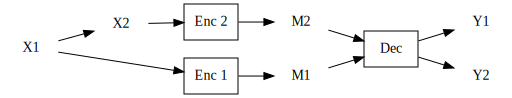

In [2]:
X1, X2 = rv_array("X", 1, 3)
Y1, Y2 = rv_array("Y", 1, 3)
M1, M2 = rv_array("M", 1, 3)
R1, R2 = real_array("R", 1, 3)
U1, U2 = rv_array("U", 1, 3)
Q = rv("Q")

model = CodingModel()        # Define distributed lossy compression
model.set_rate(M1, R1)       # The rate of M1, M2 are R1, R2 resp.
model.set_rate(M2, R2)
model.add_edge(X1, X2)       # X1, X2 are correlated source
model.add_node(X1, M1,
            label = "Enc 1") # Encoder 1 maps X1 to M1
model.add_node(X2, M2,
            label = "Enc 2") # Encoder 2 maps X2 to M2
model.add_node(M1+M2, Y1+Y2,
            label = "Dec")   # Decoder maps M1,M2 to X1,X2

model.graph()                # Draw diagram

In [3]:
r = model.get_inner(convexify = True)  # Automatic inner bound
r

( ( R2 >= I(A_M2&X2|Q_T+A_M1) )
 &( R1 >= I(A_M1&X1|Q_T)-I(A_M1&A_M2|Q_T) )
 &( R1+R2 >= I(A_M2+A_M1&X1+X2|Q_T) )
 &( indep(Q_T, X1+X2) )
 &( markov(X1, Q_T+X2, A_M2) )
 &( markov(X2+A_M2, Q_T+X1, A_M1) )
 &( markov(X1+X2, Q_T+A_M1+A_M2, Y2+Y1) ) ).exists(A_M1+A_M2+Q_T)

In [4]:
# Although the above region does not look like the Berger-Tung inner bound 
#  [Berger 1978], [Tung 1978], they are actually equivalent.

# Write the Berger-Tung inner bound
r_bt = alland([
        R1 >= I(X1 & U1 | U2+Q),
        R2 >= I(X2 & U2 | U1+Q),
        R1+R2 >= I(X1+X2 & U1+U2 | Q),
        indep(Q, X1+X2),
        markov(U1, X1+Q, X2),
        markov(U2, X2+Q, X1+U1),
        markov(Y1+Y2, U1+U2+Q, X1+X2)
    ]).exists(U1+U2+Q)
r_bt

( ( R1 >= I(X1&U1|U2+Q) )
 &( R2 >= I(X2&U2|U1+Q) )
 &( R1+R2 >= I(X1+X2&U1+U2|Q) )
 &( indep(Q, X1+X2) )
 &( markov(X1, Q+X2, U2) )
 &( markov(X2+U2, Q+X1, U1) )
 &( markov(X1+X2, Q+U1+U2, Y1+Y2) ) ).exists(U1+U2+Q)

In [5]:
r.equiv(r_bt)  # Prove r is the same region as r_bt

True

In [6]:
# Write the Berger-Tung outer bound [Berger 1978], [Tung 1978]
r_bt_out = alland([
        R1 >= I(X1+X2 & U1 | U2),
        R2 >= I(X1+X2 & U2 | U1),
        R1+R2 >= I(X1+X2 & U1+U2),
        markov(Y1+Y2, U1+U2, X1+X2),
        markov(U1, X1, X2),
        markov(U2, X2, X1)
    ]).exists(U1+U2)
r_bt_out

( ( R1 >= I(X1+X2&U1|U2) )
 &( R2 >= I(X1+X2&U2|U1) )
 &( R1+R2 >= I(X1+X2&U1+U2) )
 &( markov(U1, X1, X2) )
 &( markov(X1+X2, U1+U2, Y1+Y2) )
 &( markov(U2, X2, X1) ) ).exists(U1+U2)

In [7]:
r_out = model.get_outer(future = False)  # Automatic outer bound

# Proof that Berger-Tung outer bound is an outer bound
CompArray((r_out >> r_bt_out).check_getaux())

CompArray(
[[U1, X1_P+M1],
 [U2, X1_P+M2]])

### References
- T. Berger, "Multiterminal source coding," in The Information Theory Approach to Communications, G. Longo, Ed. New York: Springer-Verlag, 1978, pp. 171–231.
- S.-Y. Tung, "Multiterminal source coding," Ph.D. dissertation, Cornell University, Ithaca, NY, 1978.
